In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

plt.rcParams.update({'font.size': 2})

In [2]:
def apply_canny(image, threshold1=100, threshold2=230):
    return cv2.Canny(np.uint8(image), threshold1=threshold1,
                     threshold2=threshold2)

def binarize_image(image):
    # 0 is a throwaway param, Otsu will determine
    threshold, binarized = \
        cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    binarized = (image < threshold).astype(int)  # sets a higher threshold
    return binarized

# Input:
#  - cluster: List of (x, y) coordinates corresponding to points in the cluster
#  - coordinate_bounds: The shape of the original image, in (x, y) form.
# Output:
#  - centroid: [x, y]
#  - box_x: [min_x, max_x] of the bounding box
#  - box_y: [min_y, max_y] of the bounding box
def compute_centroid(cluster, coordinate_bounds):
    # cast early so we don't have to cast the boxes
    y, x = np.mean(cluster, axis=0).astype(int)
    centroid = [x, y]

    min_x = np.min(cluster[:, 1])
    max_x = np.max(cluster[:, 1])
    size_x = max_x - min_x
    box_x = [max(0, x - size_x), min(coordinate_bounds[1], x + size_x)]

    min_y = np.min(cluster[:, 0])
    max_y = np.max(cluster[:, 0])
    size_y = max_y - min_y
    box_y = [max(0, y - size_y), min(coordinate_bounds[0], y + size_y)]
    
    return centroid, box_x, box_y

def display_centroids(image, centroids, dpi=150):
    plt.figure(dpi=dpi)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), c='r', marker='+')
    plt.show()
    
def display_image_array(im_arr, columns=7, dpi=240):
    rows = int(len(im_arr) / columns) + 1
    plt.figure(dpi=dpi)
    for i in range(len(im_arr)):
        plt.subplot(rows,columns,i+1)
        plt.imshow(im_arr[i], interpolation='nearest', cmap='gray')
    plt.show()
    
def get_sub_images(image, boxes_x, boxes_y):
    boxes = []
    for i in range(len(boxes_x)):
        box = image[max(0,box_y[0]):min(box_y[1],image.shape[0]),
                    max(0,box_x[0]):min(box_x[1],image.shape[1])]
        boxes += [box,]
    return boxes

# Input:
#  - image: binary image
#  - threshold [0-1]: only remove elements less that make up less than threshold
#                     amount of total elements
#  - connectivity: 4 to exclude diagonals, 8 to include
def remove_border_elements(image, threshold=0.25, connectivity=8):
    num_components, labelled, stats, centroids = \
        cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S) 
    total_size = sum(stats[1:,-1])  # label 0 is the background component

    border_filter = np.ones(labelled.shape).astype(int)
    border_filter[1:-1, 1:-1] = 0

    for c in range(1, num_components):  # label 0 is the background component
        component = (labelled == c).astype(int)
        if np.sum(component & border_filter) > 0 and \
           np.sum(component) < threshold*total_size:
            image = image & (1-component)
    
    return image

def update_tracking(new_image, centroids, boxes_x, boxes_y):
    new_centroids = []
    new_boxes_x = []
    new_boxes_y = []
    for i in range(len(centroids)):
        centroid = centroids[i]
        box_x = boxes_x[i]
        box_y = boxes_y[i]

        box = new_image[max(0,box_y[0]):min(box_y[1],image.shape[0]),
                        max(0,box_x[0]):min(box_x[1],image.shape[1])]
        filtered = apply_canny(box)
        cluster = np.argwhere(remove_border_elements(filtered))

        # Need to ensure cell is inside the box
        if len(cluster) > 0:
            sub_centroid, sub_box_x, sub_box_y = \
                compute_centroid(cluster, coordinate_bounds)

            centroid = np.array(sub_centroid) + np.array([box_x[0], box_y[0]])
            box_x = sub_box_x + box_x[0]
            box_y = sub_box_x + box_y[0]

            new_centroids += [centroid,]
            new_boxes_x += [box_x,]
            new_boxes_y += [box_y,]

    return np.array(new_centroids), np.array(new_boxes_x), np.array(new_boxes_y)

# Read initial image and find centroids

Image dimensions: (832, 1128)


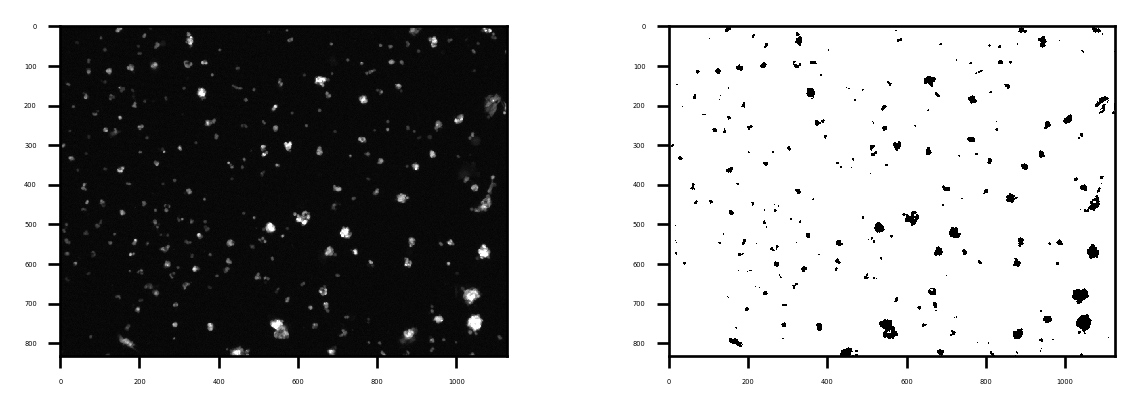

In [3]:
rfp = cv2.imreadmulti('RFP-1.tif')[1]
# bf = cv2.imreadmulti('BF-1.tif')[1]

initial_image = rfp[0]
initial_binarized = binarize_image(initial_image)

coordinate_bounds = initial_image.shape
print("Image dimensions: " + str(coordinate_bounds))

display_image_array([initial_image, initial_binarized], columns=2)

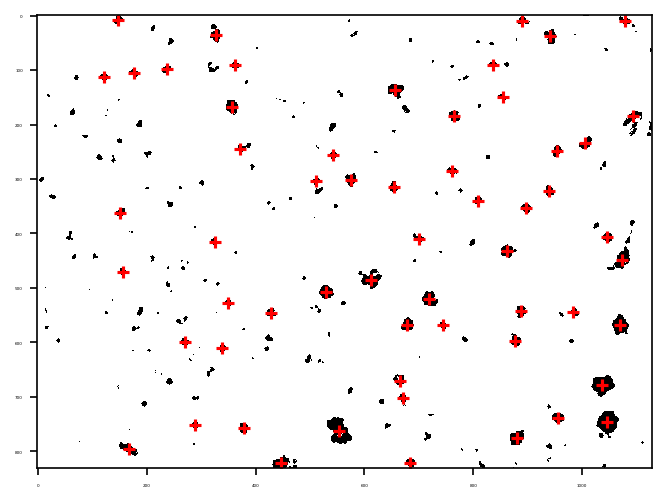

In [4]:
cell_points = np.argwhere(1-initial_binarized)
clustering = DBSCAN(eps=6, min_samples=100).fit(cell_points)
labels = clustering.labels_

centroids = []
boxes_x = []
boxes_y = []

# Note that clustering.labels_ includes -1, which are noisy samples.
# Thus, enforce starting at 0 rather than min(labels).
for i in range(0, max(labels)+1):
    indices = np.where(labels == i)
    cluster = cell_points[indices]
    
    centroid, box_x, box_y = compute_centroid(cluster, coordinate_bounds)

    centroids += [centroid,]
    boxes_x += [box_x,]
    boxes_y += [box_y,]
    
centroids = np.array(centroids)
boxes_x = np.array(boxes_x)
boxes_y = np.array(boxes_y)

display_centroids(initial_binarized, centroids)

# Iterate on second image

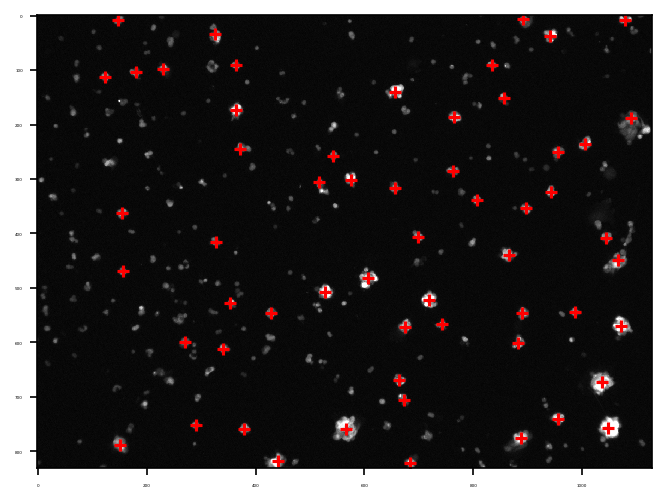

In [5]:
image = rfp[1]

# saving boxes for display purposes
boxes = []
filtered_boxes = []

new_centroids = []
new_boxes_x = []
new_boxes_y = []
for i in range(len(centroids)):
    centroid = centroids[i]
    box_x = boxes_x[i]
    box_y = boxes_y[i]

    box = image[max(0,box_y[0]):min(box_y[1],image.shape[0]),
                max(0,box_x[0]):min(box_x[1],image.shape[1])]
    filtered = apply_canny(box)
    cluster = np.argwhere(remove_border_elements(filtered))
    boxes += [box,]
    filtered_boxes += [filtered,]

    # Need to ensure cell is inside the box
    if len(cluster) > 0:
        sub_centroid, sub_box_x, sub_box_y = \
            compute_centroid(cluster, coordinate_bounds)

        centroid = np.array(sub_centroid) + np.array([box_x[0], box_y[0]])
        box_x = sub_box_x + box_x[0]
        box_y = sub_box_x + box_y[0]

        new_centroids += [centroid,]
        new_boxes_x += [box_x,]
        new_boxes_y += [box_y,]

new_centroids = np.array(new_centroids)
new_boxes_x = np.array(new_boxes_x)
new_boxes_y = np.array(new_boxes_y)

display_centroids(image, new_centroids)

# Pipeline sanity check

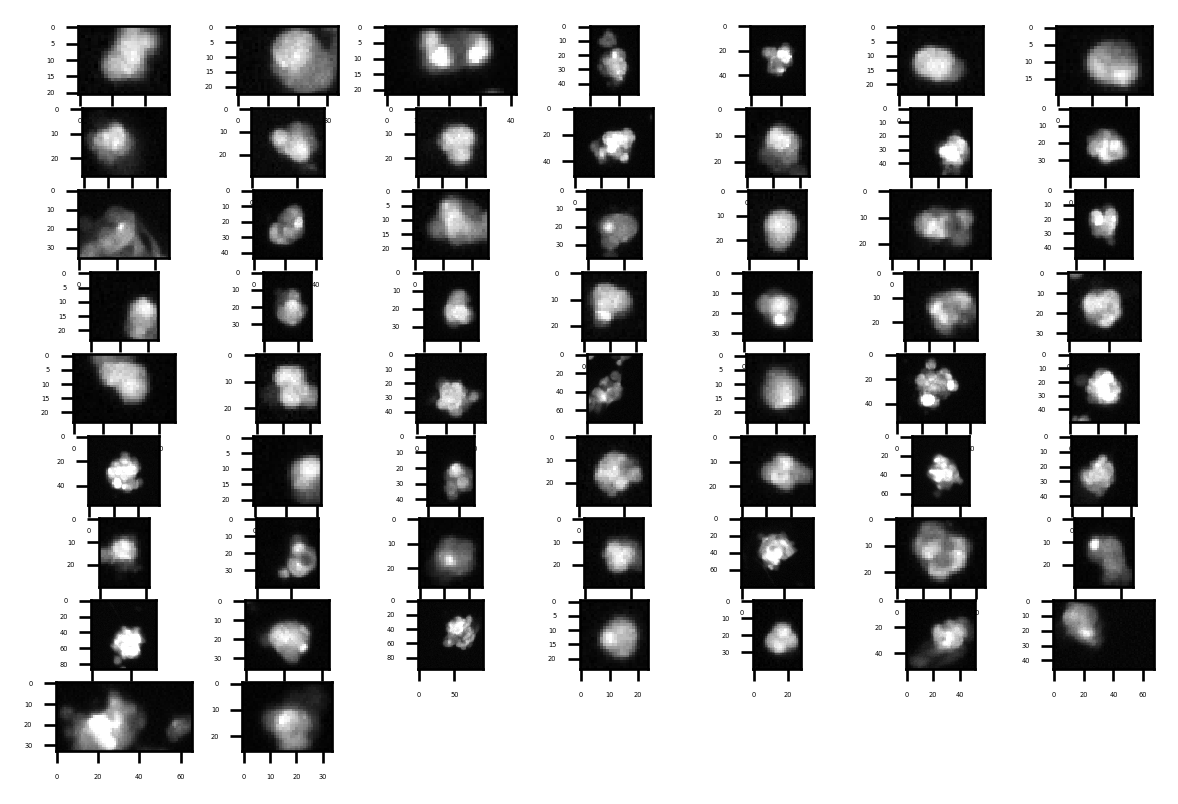

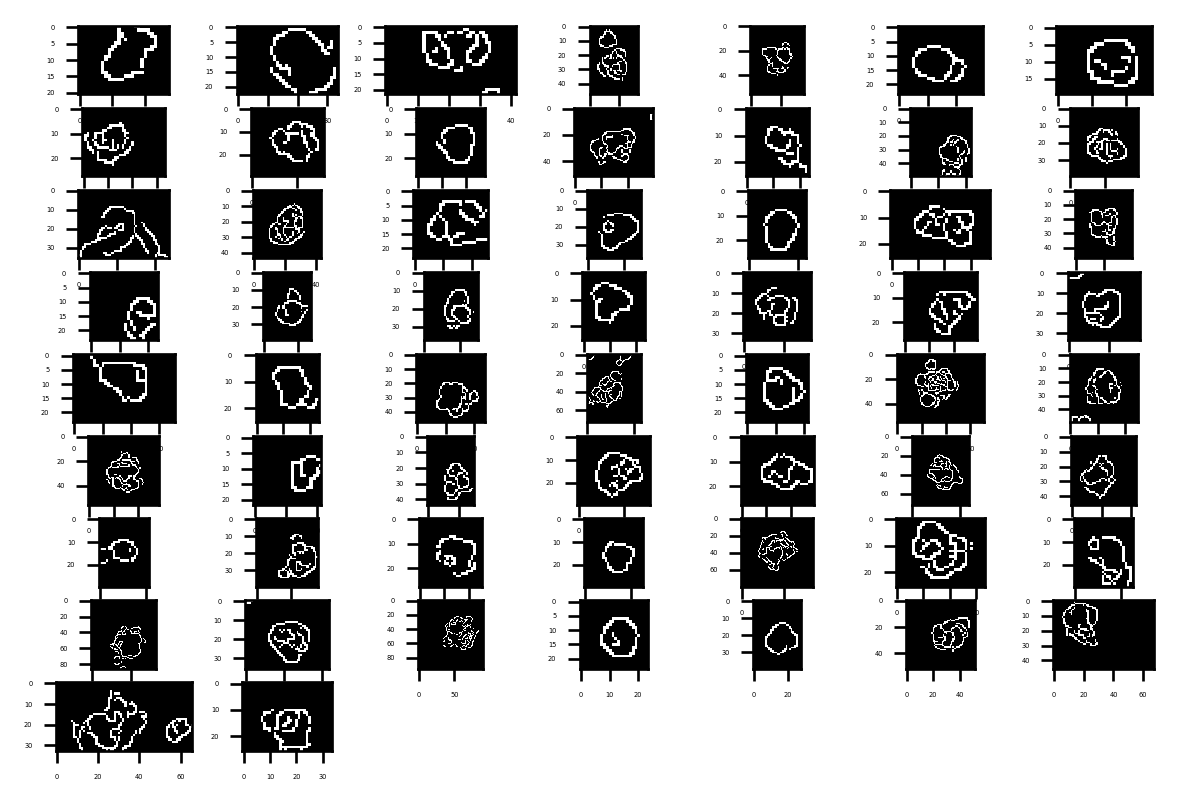

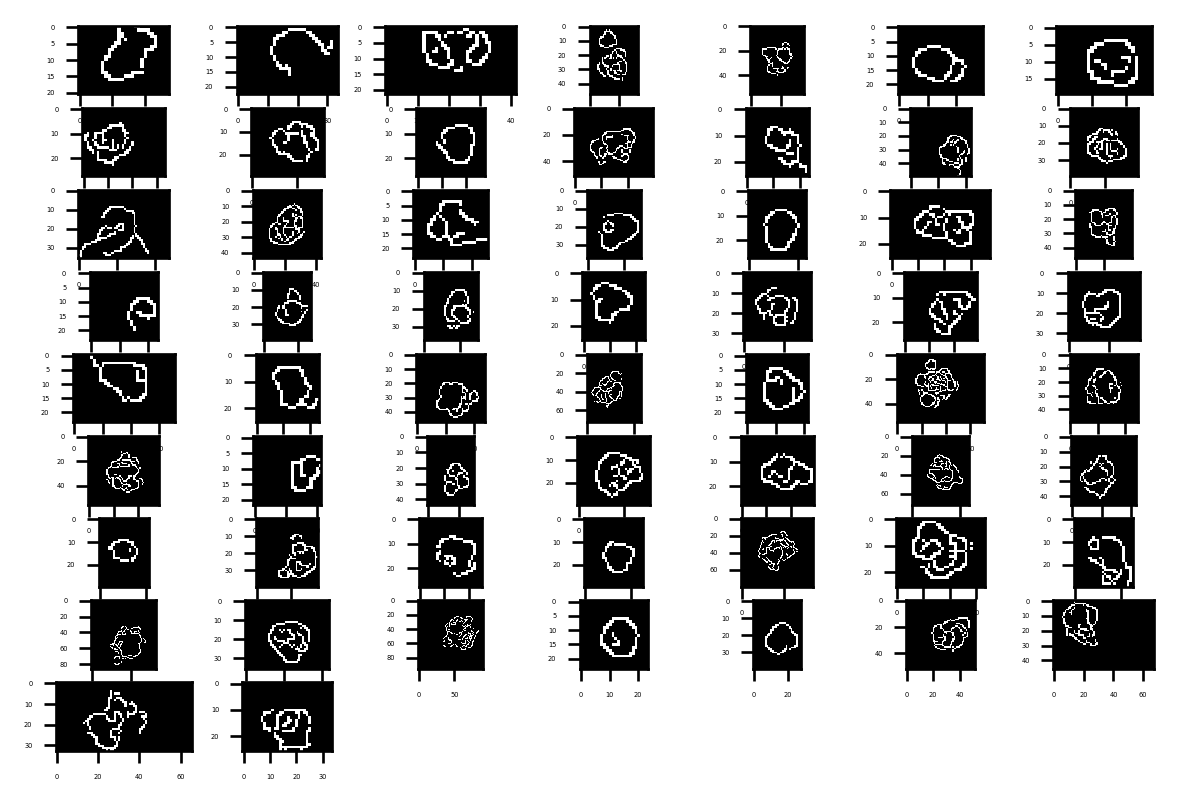

In [6]:
display_image_array(boxes)
display_image_array([apply_canny(box) for box in boxes])
display_image_array([remove_border_elements(apply_canny(box)) for box in boxes])

# Proof of Concept for LoG and Canny

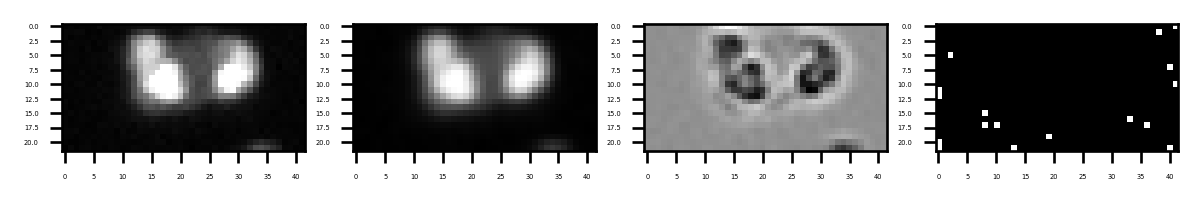

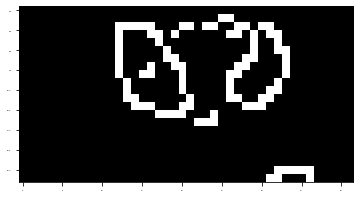

In [7]:
centroid = centroids[2]
box_x = boxes_x[2]
box_y = boxes_y[2]

# LoG
image = rfp[1]
box = image[box_y[0]:box_y[1], box_x[0]:box_x[1]]
blurred = cv2.GaussianBlur(np.float64(box), (3,3), 0)
filtered = cv2.Laplacian(np.float64(blurred), cv2.CV_64F)
edges = (filtered == 0).astype(int)  # need to threshold this

display_image_array([box, blurred, filtered, edges], columns=4)

# Canny
box = rfp[1][box_y[0]:box_y[1], box_x[0]:box_x[1]]
plt.imshow(apply_canny(box), interpolation='nearest', cmap='gray')